In [96]:
##PPXF code to get stellar maps using Michelle Cappellari (2017) code


import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
from os import path


from ppxf.ppxf import ppxf, robust_sigma

import ppxf.ppxf_util as util
import ppxf.miles_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from plotbin.display_bins import display_pixels
from plotbin.plot_velfield import plot_velfield

C = 299792.458  # speed of light in km/s

In [97]:
class read_muse_cube(object):
    def __init__(self, wave_range):
        """
        Read MUSE cube, log rebin it and compute coordinates of each spaxel.
        Median FWHM resolution = 2.62Å. Range: 2.51--2.88 (ESOpPXF Purpose
        instrument manual)
        
        """
        filename = '/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/ppxf_spax.fits'  
        hdu = pyfits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data   

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1) # create array of spectra [npix, nx*ny]
        wave = (head['CRVAL3'] + head['CDELT3']*np.arange(npix))   
        pixsize = abs(head["CDELT1"])*3600    # 0.2"

        # Only use a restricted wavelength range
        w = (wave > wave_range[0]) & (wave < wave_range[1])
        spectra = spectra[w, :]
        
        wave = wave[w]/(1+0.02964)

        # Create coordinates centred on the brightest spectrum
        flux = np.nanmean(spectra, 0)
        jm = np.argmax(flux)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*pixsize
        y = (row - row[jm])*pixsize
        velscale = 46.27319167       #C*np.diff(np.log(wave[-2:])) # Smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)
        
        self.spectra = spectra
        self.cube=cube
        self.x = x
        self.y = y
        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.flux = flux
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = 2.62  # Median FWHM resolution of MUSE

In [98]:
def clip_outliers(galaxy, bestfit, goodpixels):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma
    in relative error until the bad bins don't change any more.
    """
    while True:
        scale = galaxy[goodpixels] @ bestfit[goodpixels]/np.sum(bestfit[goodpixels]**2)
        resid = scale*bestfit[goodpixels] - galaxy[goodpixels]
        err = robust_sigma(resid, zero=1)
        ok_old = goodpixels
        goodpixels = np.flatnonzero(np.abs(bestfit - galaxy) < 3*err)
        if np.array_equal(goodpixels, ok_old):
            break
            
    return goodpixels


In [162]:
def fit_and_clean(templates, galaxy, velscale, start, goodpixels0, lam, lam_temp):
    
    print('##############################################################')
    goodpixels = goodpixels0.copy()
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels)

    plt.figure(figsize=(40, 5))
    #plt.subplot(121)
    #pp.plot()

    goodpixels = clip_outliers(galaxy, pp.bestfit, goodpixels)

    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    goodpixels = np.intersect1d(goodpixels, goodpixels0)
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels)
    
    plt.subplot(122)
    pp.plot()

    optimal_template = templates @ pp.weights
    
    return pp, optimal_template


In [100]:
lam_range_temp = [4610, 8800]   
s = read_muse_cube(lam_range_temp)


In [111]:
signal = np.median(s.spectra, 0)
noise = np.sqrt(signal)
target_sn = 25

######## 3 x 6 arcsec cube ############

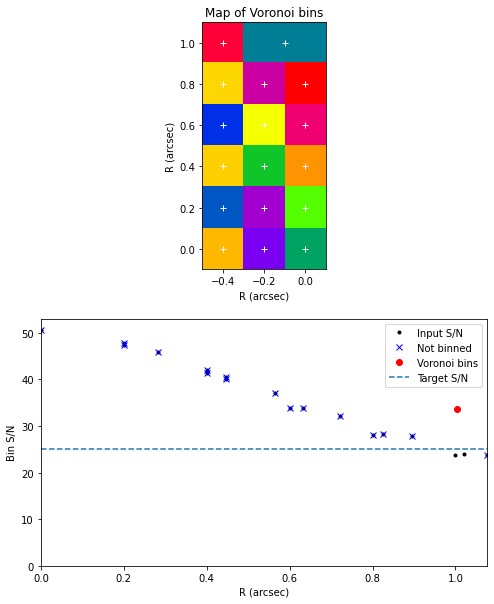

In [112]:
plt.figure(figsize=(8,10))
bin_num, x_gen, y_gen, xbin, ybin, sn, nPixels, scale = voronoi_2d_binning(s.x, s.y, signal, noise, target_sn,pixelsize=0.2, plot=1, quiet=1)

In [113]:
velscale=46.27319167
#C*np.diff(s.ln_lam_gal[:2])   # eq.(8) of Cappellari (2017)
velscale

46.27319167

In [114]:
ppxf_dir = '/home/arshi/anaconda3/lib/python3.9/site-packages/ppxf-8.2.3/ppxf'
pathname = ppxf_dir + '/miles_models/Eun1.30*.fits'
FWHM_gal = None   # set this to None to skip convolutiona
miles = lib.miles(pathname, velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = miles.templates, miles.ln_lam_temp
ln_lam_temp


array([ 7.42647743,  7.42663178,  7.42678613, ..., 10.81926133,
       10.81941568, 10.81957003])

In [115]:
reg_dim = stars_templates.shape[1:]
stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)

stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error


In [116]:
#z = 0.002964
z_og=0.02964# redshift estimate from NED
vel0 =0#C*np.log(1 + z)  # Initial estimate of the galaxy velocity in km/s. eq. (8) of Cappellari (2017)
start = [vel0, 200.]  # (km/s), starting guess for [V,sigma]


In [117]:
lam_range_temp = np.exp(ln_lam_temp[[0, -1]])
goodpixels0 = util.determine_goodpixels(s.ln_lam_gal+np.log(1+z_og), lam_range_temp, z_og, width=1000)


In [118]:
nbins = sn.size
velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
optimal_templates = np.empty((stars_templates.shape[0], nbins))
nbins

17

##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -1       218
chi2/DOF: 5792.; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
 Best Fit:       Vel     sigma
 comp.  0:        -4       238
chi2/DOF: 2073.; DOF: 3742; degree = -1; mdegree = 4
method = capfit; Jac calls: 8; Func calls: 61; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.91
Weighted <[M/H]>: 0.0173
Voronoi bin: 1 / 17
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:        -2       236
chi2/DOF: 4255.; DOF: 3875; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 44; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:        -6       240
chi2/DOF: 1830.; DOF: 3775; degree = -1; mdegree

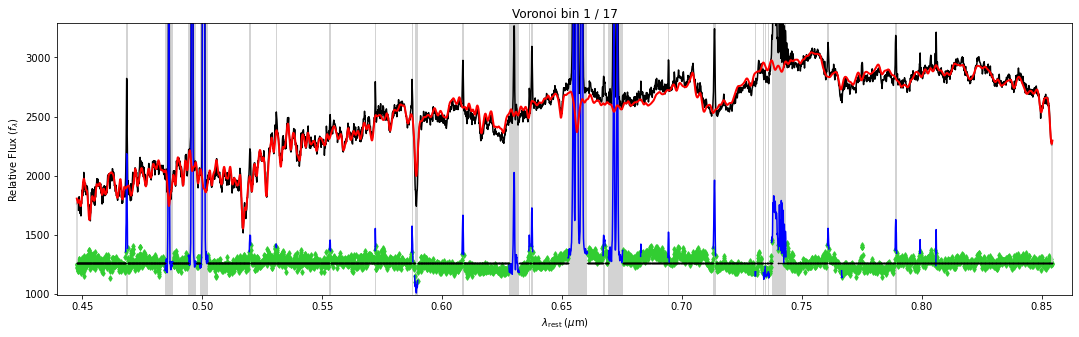

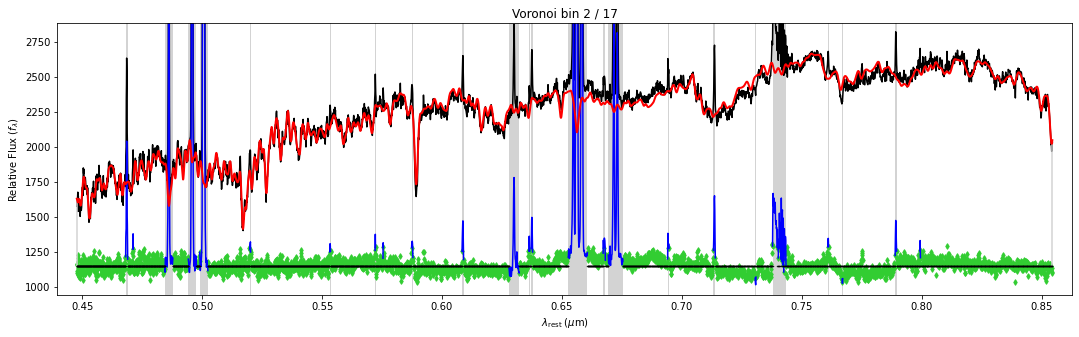

In [163]:
lam_gal = np.exp(s.ln_lam_gal)
for j in range(2):
    w = bin_num == j
    galaxy = np.sum(s.spectra[:, w], 1)
    pp, bestfit_template = fit_and_clean(stars_templates, galaxy, velscale, start, goodpixels0, lam_gal, miles.lam_temp)
    velbin[j], sigbin[j] = pp.sol
    optimal_templates[:, j] = bestfit_template
    light_weights = pp.weights.reshape(reg_dim)
    lg_age_bin[j], metalbin[j] = miles.mean_age_metal(light_weights)

    print(f'Voronoi bin: {j + 1} / {nbins}')
    plt.title(f"Voronoi bin {j + 1} / {nbins}")



/home/arshi/anaconda3/lib/python3.9/site-packages/plotbin-3.1.3-py3.9.egg/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
/home/arshi/anaconda3/lib/python3.9/site-packages/plotbin-3.1.3-py3.9.egg/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.


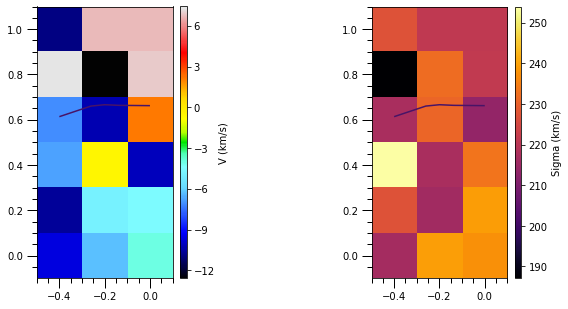

In [120]:
plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
display_bins(s.x, s.y, bin_num, velbin,pixelsize=0.2, colorbar=1, label='V (km/s)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

plt.subplot(122)
display_bins(s.x, s.y, bin_num, sigbin,pixelsize=0.2, colorbar=1, cmap='inferno', label='Sigma (km/s)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

In [ ]:
#import pandas as pd 
#pd.DataFrame(s.x,s.y).to_csv("/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/coord.csv")

In [155]:
f = open("/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/test.csv", "w")
f.write("{},{},{},{},{},{}\n".format("x", "y","bin","vel","sig","flux"))
for x in zip(s.x, s.y,bin_num,velbin,sigbin,s.flux):
    f.write("{},{},{},{},{},{}\n".format(x[0], x[1], x[2], x[3], x[4], x[5]))
f.close()


In [157]:
import pandas as pd 
file='/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/test.csv'
data=pd.read_csv(file)
data

,x,y,bin,vel,sig,flux
0,-0.4,0.0,4,-3.940992,237.764533,1788.899414
1,-0.2,0.0,1,-6.197845,239.620007,2333.361328
2,0.0,0.0,0,-4.791878,216.107309,2608.417725
3,-0.4,0.2,5,-4.438858,239.387332,1667.631714
4,-0.2,0.2,2,-9.545005,216.729319,2138.244385
5,0.0,0.2,3,-10.538184,227.576884,2321.920166
6,-0.4,0.4,8,-0.437377,217.624164,1379.109009
7,-0.2,0.4,6,-10.030582,233.483279,1648.322388
8,0.0,0.4,7,-6.655739,253.982552,1754.873535
9,-0.4,0.6,10,-10.193813,231.113049,1034.014282


In [158]:
a1=np.array(data.vel)
velocity=np.reshape(a1, (6,3))

a2=np.array(data.sig)
disp=np.reshape(a2, (6,3))

a3=np.array(data.flux)
flux=np.reshape(a3, (6,3))

a4=np.array(data.bin)
bin=np.reshape(a4, (6,3))


In [159]:
        filename = '/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/ppxf_spax.fits'  
        hdu = pyfits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data
        hdu.info()

Filename: /home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/ppxf_spax.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      42   (3, 6, 3802)   float32   


In [160]:
new_hdul = pyfits.HDUList()
new_hdul.append(pyfits.ImageHDU(np.zeros((1,1)), name="Primary"))
new_hdul.append(pyfits.ImageHDU(cube, name="MUSE CUBE"))
new_hdul.append(pyfits.ImageHDU(bin, name="BIN/ SPAXELS"))
new_hdul.append(pyfits.ImageHDU(velocity, name="velocity"))
new_hdul.append(pyfits.ImageHDU(disp, name="stellar dispersion"))
new_hdul.append(pyfits.ImageHDU(flux, name="Flux"))

new_hdul.writeto("/home/arshi/Downloads/ADP.2019-06-07T06 12 58.346/test.fits", overwrite=True)